---
#Import 📥​
---

In [1]:
#Librerie
import os
import re
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torch.distributions.uniform import Uniform
from torchvision import transforms
from torchvision.transforms import ToPILImage
import shutil
from PIL import Image
from PIL import ImageChops
import numpy as np
from tqdm.notebook import tqdm
from tqdm import tqdm
import librosa
import librosa.display
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import Audio, display

from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/MyDrive/Progetto Machine Learning/Pkmn"

Mounted at /content/drive
/content/drive/MyDrive/Progetto Machine Learning/Pkmn


---
# Pokédex 🗃️​
---

In questa sezione viene definito il nostro `Database`, distinguendo i Pokémon in varie classi.  
Dopodiché, vengono assegnati ad ogni Pokémon le proprie caratteristiche, tra cui anche i percorsi file per richiamare versi e sprite.  
Infine, si aggiunge la frequenza media del verso per ciascun mostriciattolo tascabile.





In [2]:
starters = ['Bulbasaur' , 'Ivysaur' , 'Venusaur',
            'Charmander' , 'Charmeleon' , 'Charizard',
            'Squirtle' , 'Wartortle' , 'Blastoise',
            'Chikorita' , 'Bayleef' , 'Meganium',
            'Cyndaquil' , 'Quilava'  ,'Typhlosion',
            'Totodile' , 'Croconaw' , 'Feraligatr',
            'Treecko' , 'Grovyle' , 'Sceptile',
            'Torchic' , 'Combusken' , 'Blaziken',
            'Mudkip' , 'Marshtomp' , 'Swampert',
            'Turtwig', 'Grotle', 'Torterra',
            'Chimchar' , 'Monferno' , 'Infernape',
            'Piplup', 'Prinplup' , 'Empoleon',
            'Snivy', 'Servine', 'Serperior',
            'Tepig' , 'Pignite' , 'Emboar',
            'Oshawott' , 'Dewott' , 'Samurott']

eevee = ['Vaporeon', 'Jolteon', 'Flareon', 'Espeon', 'Umbreon', 'Leafeon', 'Glaceon']

legendary = ['Articuno', 'Zapdos', 'Moltres', 'Mewtwo',
             "Raikou", "Entei", "Suicune", 'Lugia','Ho-oh',
             'Regirock', 'Regice', 'Registeel', 'Latias', 'Latios', 'Groudon', 'Kyogre', 'Rayquaza',
             'Uxie', 'Mesprit', 'Azelf', 'Dialga','Palkia','Giratina', 'Heatran', 'Regigigas', 'Cresselia',
             'Cobalion', 'Terrakion', 'Virizion', 'Tornadus', 'Thundurus', 'Landorus', 'Reshiram', 'Zekrom', 'Kyurem']

pseudo = ['Dragonite','Dragonair','Dratini',
          'Tyranitar','Pupitar','Larvitar',
          'Salamence','Shelgon', 'Bagon','Metagross','Metang','Beldum',
          'Garchomp','Gabite','Gible',
          'Hydreigon','Zweilous','Deino']

myth = ['Mew',
        'Celebi',
        'Deoxys', 'Jirachi',
        'Arceus', 'Darkrai', 'Manaphy', 'Phione', 'Shaymin',
        'Genesect', 'Keldeo', 'Meloetta', 'Victini']

fossil = ['Kabuto' , 'Kabutops', 'Omanyte' , 'Omastar' , 'Aerodactyl',
          'Anorith' , 'Armaldo',  'Lileep' , 'Cradily' ,
          'Cranidos' , 'Rampardos' , 'Shieldon' , 'Bastiodon' ,
          'Tirtouga' , 'Carracosta' , 'Archen' , 'Archeops']

In [3]:
pkms = {}

with open("lista_caratteristiche.txt", encoding="utf-8") as file:
    for line in file:
        parts = line.strip().split(",")
        nome = parts[2]
        pkms[nome] = {}
        pkms[nome]['types'] = [t for t in parts[3:] if t]
        if nome in starters:
          pkms[nome]['class'] = 'starter'
        elif nome in eevee:
          pkms[nome]['class'] = 'eeveelution'
        elif nome in legendary:
          pkms[nome]['class'] = 'legendary'
        elif nome in pseudo:
          pkms[nome]['class'] = 'pseudo-legendary'
        elif nome in myth:
          pkms[nome]['class'] = 'mythical'
        elif nome in fossil:
          pkms[nome]['class'] = 'fossil'
        else:
          pkms[nome]['class'] = 'common'
        pkms[nome]['mass'] = parts[0]
        pkms[nome]['sprite'] = "SpritesPKMN/" +nome+ ".png"
        pkms[nome]['cry'] = "CriesPKMN/" +nome+ ".ogg"
        if len(pkms[nome]['types']) == 1:
          tps = pkms[nome]['types'][0]
        else:
          tps = ' and '.join(pkms[nome]['types'])
        pkms[nome]['description'] = tps +' '+ pkms[nome]['class']+ ' Pokémon similar to '+ nome

In [ ]:
def Hz(p):
  audio, sr = librosa.load(pkms[p]['cry'], sr=None)
  spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
  mean_centroid = np.mean(spectral_centroid)
  return round(float(mean_centroid), 2)

def Add_Hz(diz):
  for x in diz:
    diz[x]['freq'] = Hz(x)

Add_Hz(pkms)

'''
Map_F = {'0-1800': 270, '2000-2500': 262, '2500 or more': 117}
Queste sono le fasce di frequenze distribuite in modo che la quantità
di pokemon nelle fasce sia più o meno simile
'''

---
#Dataset 📋​
---

Definiamo una classe `Dataset` che consente di gestire in modo unificato sprite, audio, tipi e categorie dei Pokémon.  
L'obiettivo di questa cella è quello di fornire un encoding numerico delle informazion testuali e una pipeline di trasformazioni grafiche, rendendoli pronti per la fase di training.

In [ ]:
def crop_non_black(img):
    bg = Image.new(img.mode, img.size, (0, 0, 0))
    diff = ImageChops.difference(img, bg)
    bbox = diff.getbbox()
    if bbox:
        return img.crop(bbox)
    return img


class PokemonDataset(Dataset):
    def __init__(self, data_dict, image_size=(96, 96), root_dir='.', transform=None):  #ATTENZONE 96X96
        self.data = []
        self.image_size = image_size
        self.root_dir = root_dir


        self.all_types = sorted({t for v in data_dict.values() for t in v['types']})
        unique_classes = sorted({v['class'] for v in data_dict.values()})
        self.class_map = {cls_name: i for i, cls_name in enumerate(unique_classes)}


        self.type_to_idx = {t: i for i, t in enumerate(self.all_types)}
        self.num_types = len(self.all_types)

        for name, attrs in data_dict.items():
            types = attrs['types']
            class_label = attrs['class']
            sprite_path = os.path.join(root_dir, attrs['sprite'])
            cry_path = os.path.join(root_dir, attrs['cry'])
            description = attrs['description']


            type_encoding = torch.zeros(self.num_types)
            for t in types:
                type_encoding[self.type_to_idx[t]] = 1

            class_encoding = torch.tensor([self.class_map[class_label]], dtype=torch.long)

            self.data.append({
                'name': name,
                'types': type_encoding,
                'class': class_encoding,
                'sprite_path': sprite_path,
                'cry_path': cry_path,
                'description': description})


        self.transform = transform or transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        image = Image.open(entry['sprite_path']).convert("RGB")
        image = crop_non_black(image)
        image = self.transform(image)


        return {
            'name': entry['name'],
            'sprite': image,
            'types': entry['types'],
            'class': entry['class'],
            'cry_path': entry['cry_path'],
            'description': entry['description']}

In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + 1e-5)])

pokemon_root_dir = os.getcwd()

pkms_dataset = PokemonDataset(pkms, image_size=(64, 64), root_dir=pokemon_root_dir, transform=transform)

#pkms_dataset[82]

---
#Algoritmo musicale 🎧​ (Luca Montefusco)
---

In questa prima cella, grazie alle funzioni `TakeInput` e `SearchPkmn` definiamo una lista di Pokémon che si trovano nel range della frequenza media della canzone.  
Successivamente si costruisce un’istanza del dataset pronta per l’utilizzo nei modelli neurali, ovvero: `Variational Autoencoder (VAE)` per la rappresentazione e generazione dei dati, e un `Discriminatore in stile GAN` per introdurre un termine avversario in fase di addestramento.  
L’encoder del VAE mappa i dati, il decoder ricostruisce le immagini e il discriminatore valuta la qualità delle ricostruzioni.  
Per facilitare il procedimento di allenamento, e per evitare problemi, viene introdotta una funzione di `salvataggio di checkpoints`.

In [ ]:
def TakeInput(name: str):
  audio, sr = librosa.load('Input/' + name + '.mp3', sr=None)
  spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
  mean_centroid = np.mean(spectral_centroid)
  return round(float(mean_centroid), 2)

def SearchPkmn(name: str):
  Found_pkmn = []
  H = TakeInput(name)
  for p in pkms:
    freq = pkms[p]['freq']
    if freq <= H+320 and freq >= H-320:
      Found_pkmn.append(p)
  return Found_pkmn

#SearchPkmn('SbH') #Test usando Super Massive Blackhole

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [ ]:
# 2. VAE (Encoder + Decoder)
class Encoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2))

        self.fc_mu = nn.Linear(256*4*4, latent_dim)
        self.fc_logvar = nn.Linear(256*4*4, latent_dim)

    def forward(self, x):
        h = self.conv(x).view(x.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar


class Decoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 256*4*4)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Tanh())


    def forward(self, z):
        h = self.fc(z).view(z.size(0), 256, 4, 4)
        return self.deconv(h)


class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        recon = self.decoder(z)
        return recon, mu, logvar


# 3. Gan
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, 4, 1, 0))


    def forward(self, x):
        return self.conv(x).view(-1, 1)

In [ ]:
# 4. Loss functions
def kld_loss(mu, logvar):
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

bce = nn.BCELoss()

In [ ]:
# 5. DataLoader
from torch.utils.data import random_split
val_ratio = 0.1  # 10% validation
val_size = int(len(pkms_dataset) * val_ratio)
train_size = len(pkms_dataset) - val_size

train_dataset, val_dataset = random_split(pkms_dataset, [train_size, val_size])

loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    drop_last=True,
    num_workers=2,
    pin_memory=True)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,
    drop_last=False,
    num_workers=2,
    pin_memory=True)

In [ ]:
# 6. Init modelli
latent_dim = 128
vae = VAE(latent_dim).to(device)
D = Discriminator().to(device)

opt_VAE = torch.optim.Adam(vae.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

# Cartella per i checkpoint
os.makedirs("checkpoints", exist_ok=True)

start_epoch = 0

In [ ]:
# 7. Carica checkpoint se disponibile
ckpt_path = "checkpoints/pokemon_vae_gan.pth"
reset = False  #True riparte da zero, False mantiene

if os.path.exists(ckpt_path) and not reset:
    checkpoint = torch.load(ckpt_path, map_location=device)
    vae.load_state_dict(checkpoint["vae"])
    D.load_state_dict(checkpoint["D"])
    opt_VAE.load_state_dict(checkpoint["opt_vae"])
    opt_D.load_state_dict(checkpoint["opt_D"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"✅ Checkpoint caricato da epoca {start_epoch}")
else:
    print("⚠️ Nessun checkpoint trovato, si parte da zero")

✅ Checkpoint caricato da epoca 320


In [ ]:
# 8. Training loop
epochs = 320
lambda_adv = 0.25   # Livello GAN (provare con altri livelli)
beta_kl = 0.1

for epoch in range(start_epoch, epochs):
    vae.train()
    D.train()

    for batch in loader:
        x = batch['sprite'].to(device)

        with torch.no_grad():
            recon, mu, logvar = vae(x)

        D_real = D(x)
        D_fake = D(recon.detach())

        loss_D = -torch.mean(torch.log(torch.sigmoid(D_real) + 1e-8) + torch.log(1 - torch.sigmoid(D_fake) + 1e-8))


        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        recon, mu, logvar = vae(x)

        rec_loss = F.l1_loss(recon, x) + 0.1 * F.mse_loss(recon, x)
        kl = kld_loss(mu, logvar)

        D_fake = D(recon)
        adv_loss = -torch.mean(torch.log(torch.sigmoid(D_fake) + 1e-8))

        loss_VAE = rec_loss + beta_kl * kl + lambda_adv * adv_loss

        opt_VAE.zero_grad()
        loss_VAE.backward()
        opt_VAE.step()

    # Validation
    vae.eval()
    val_rec, val_kl = 0.0, 0.0
    with torch.no_grad():
        for batch in val_loader:
            x = batch['sprite'].to(device)
            recon, mu, logvar = vae(x)

            val_rec += F.l1_loss(recon, x).item()
            val_kl  += kld_loss(mu, logvar).item()

    val_rec /= len(val_loader)
    val_kl  /= len(val_loader)

    print(f"[{epoch+1}/{epochs}] Train_VAE: {loss_VAE.item():.4f} | "
          f"Train_D: {loss_D.item():.4f} | "
          f"Val_Rec: {val_rec:.4f} | Val_KL: {val_kl:.4f}")

    # Salvataggio checkpoint ogni 10 epoche
    if (epoch+1) % 10 == 0:
        torch.save({
            "epoch": epoch,
            "vae": vae.state_dict(),
            "D": D.state_dict(),
            "opt_vae": opt_VAE.state_dict(),
            "opt_D": opt_D.state_dict()
        }, ckpt_path)
        print(f"💾 Checkpoint salvato all'epoca {epoch+1}")

In [ ]:
# 9. Generazione con musica

def generate_grid_from_song(song_id, vae, pkm_db, device, n_show=8):
    vae.eval()
    found_names = SearchPkmn(song_id)

    if not found_names:
        print("❌ Nessun Pokémon trovato per la canzone")
        return

    chosen = random.sample(found_names, min(n_show, len(found_names)))

    imgs = []
    for name in chosen:
        if name not in pkm_db:
            continue
        sprite_path = pkm_db[name]["sprite"]
        try:
            img = Image.open(sprite_path).convert("RGB")
            x = transform(img).unsqueeze(0).to(device)
            imgs.append(x)
        except Exception as e:
            print(f"Errore nel caricare {name}: {e}")

    if not imgs:
        print("❌ Nessuna immagine caricata")
        return

    x = torch.cat(imgs, dim=0)
    with torch.no_grad():
        recon, mu, logvar = vae(x)

    #grid = make_grid(torch.cat([x, recon]), nrow=len(x), normalize=True, value_range=(-1,1)) # pokemon nuovi e esistenti
    grid = make_grid(recon, nrow=len(x), normalize=True, value_range=(-1,1))                  # solo pokemon nuovi

    plt.figure(figsize=(4*len(x), 4))
    plt.imshow(grid.permute(1,2,0).cpu().numpy())
    plt.axis("off")
    plt.show()

---
#Algoritmo testuale 📜​ (Giacomo Tronca)
---

Nella prima parte del codice, a partire dal dataset, viene creato un dizionario che associa ad ogni elemento "tipo" e "classe" un numero, così da poter creare una rapida rappresentazione di ogni eventuale input: ogni parte del generico prompt testuale, fintanto che accettabile, può essere presa in considerazione e la macchina terrà conto delle immagini abbinate a Pokémon che hanno la determinata caratteristica letta

In [ ]:
#Crea un vocabolario basato sulle descrizioni presenti nel dataset
#per poi utilizzarle per la generazione di nuove immagini

def build_vocab(data_dict):
    vocab = {"<PAD>": 0, "<UNK>": 1}
    idx = 2
    for entry in data_dict.values():
        prompt = f"{' '.join(entry['types'])} {entry['class']}".lower()
        for word in prompt.split():
            if word not in vocab:
                vocab[word] = idx
                idx += 1
    return vocab

vocab = build_vocab(pkms)
#print(vocab)

Successivamente si passa alla definizione del modello. Tramite `PromptToSpriteDataset` ogni descrizione viene tokenizzata in un insieme di numeri secondo lo schema stabilito nel precedente vocabolario

In [ ]:
class PromptToSpriteDataset(Dataset):
    def __init__(self, data_dict, vocab, image_size=(64, 64), root_dir='.', max_len=6, transform=None):
        self.samples = []
        self.vocab = vocab
        self.max_len = max_len
        self.transform = transform or transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])

        for entry in data_dict.values():
            prompt = entry['description'].split(" similar to")[0].lower()
            tokens = [vocab.get(tok, vocab["<UNK>"]) for tok in prompt.split()]
            tokens = tokens[:max_len] + [vocab["<PAD>"]] * (max_len - len(tokens))

            sprite_path = os.path.join(root_dir, entry['sprite'])
            self.samples.append((tokens, sprite_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        tokens, sprite_path = self.samples[idx]
        image = Image.open(sprite_path).convert("RGB")
        image = self.transform(image)
        return torch.tensor(tokens, dtype=torch.long), image

Viene successivamente definito un encoder, `PromptEncoder`, per i prompt testuali, tramite cui si vettorizzano i token ottenuti in precedenza attraverso `nn.Enbedding`, e poi si definisce `SpriteDecoder` tramite il quale si trasformano gli embeddings ottenuti in immagini RGB. La classe `PromptToSpriteModel` unisce le due cose, per passare direttamente da prompt a immagine

In [ ]:
class PromptEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.encoder = nn.GRU(embed_dim, embed_dim, batch_first=True)

    def forward(self, tokens):
        embedded = self.embedding(tokens)       # [B, T, E]
        _, h = self.encoder(embedded)           # h: [1, B, E]
        return h.squeeze(0)                     # [B, E]

class SpriteDecoder(nn.Module):
    def __init__(self, input_dim=128, img_size=64):
        super().__init__()
        self.init_size = img_size // 8
        self.fc = nn.Linear(input_dim, 256 * self.init_size * self.init_size)
        self.deconv = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 3, 3, padding=1),
            nn.Tanh())

    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.size(0), 256, self.init_size, self.init_size)
        return self.deconv(out)

class PromptToSpriteModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.encoder = PromptEncoder(vocab_size)
        self.decoder = SpriteDecoder()

    def forward(self, tokens):
        z = self.encoder(tokens)
        img = self.decoder(z)
        return img

In [ ]:
def train_model(model, dataloader, epochs=10, lr=1e-4, device='cuda', checkpoint_path=None, resume=False):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    start_epoch = 0

    # Se resume=True, carica il checkpoint
    if resume and checkpoint_path and os.path.exists(checkpoint_path):
        print(f"🔄 Riprendo il training da {checkpoint_path}...")
        checkpoints = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoints['model_state_dict'])
        optimizer.load_state_dict(checkpoints['optimizer_state_dict'])
        start_epoch = checkpoints['epoch'] + 1
        print(f"📂 Ripreso da epoca {start_epoch} con loss {checkpoints['loss']:.4f}")

    # Loop di training
    for epoch in range(start_epoch, epochs):
        model.train()
        total_loss = 0.0

        print(f"\n🧠 Epoch {epoch+1}/{epochs}")
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}", leave=False)

        for tokens, targets in pbar:
            tokens = tokens.to(device)
            targets = targets.to(device)

            preds = model(tokens)
            loss = criterion(preds, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix({"batch_loss": loss.item()})

        avg_loss = total_loss / len(dataloader)
        print(f"📉 Average loss: {avg_loss:.4f}")

        # Salvataggio checkpoint
        if checkpoint_path:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss
            }, checkpoint_path)
            print(f"💾 Checkpoint salvato in {checkpoint_path}")

In [ ]:
def generate_image_from_prompt(prompt, model, vocab, device='cpu'):
    model.eval()
    # Tokenizza e trasforma prompt in tensore di indici, con padding fino a 6 token
    tokens = [vocab.get(tok, vocab.get("<UNK>", 0)) for tok in prompt.lower().split()]
    tokens = tokens[:6] + [vocab.get("<PAD>", 0)] * (6 - len(tokens))
    tokens = torch.tensor(tokens).unsqueeze(0).to(device)  # batch 1

    with torch.no_grad():
        output = model(tokens).squeeze(0).cpu()  # [3, H, W]

    output = (output + 1) / 2  # Normalizza da [-1,1] a [0,1]
    return output

def show_generated_grid(prompts, model, vocab, device='cpu'):
    assert len(prompts) == 4, "Serve una lista di 4 prompt esatti"
    images = []
    for prompt in prompts:
        img_tensor = generate_image_from_prompt(prompt, model, vocab, device)
        pil_img = ToPILImage()(img_tensor)
        images.append(pil_img)

    fig, axs = plt.subplots(2, 2, figsize=(8,8))
    axs = axs.flatten()
    for i, img in enumerate(images):
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(prompts[i])
    plt.tight_layout()
    plt.show()

In [ ]:
def show_generated(prompt, model, vocab, device='cpu'):
    img_tensor = generate_image_from_prompt(prompt, model, vocab, device)
    pil_img = ToPILImage()(img_tensor)

    plt.figure(figsize=(6,6))
    plt.imshow(pil_img)
    plt.axis('off')
    plt.title(prompt)
    plt.show()

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'
# Dataset
dataset = PromptToSpriteDataset(pkms, vocab, root_dir=pokemon_root_dir)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Modello
model = PromptToSpriteModel(vocab_size=len(vocab))

# Training
# Primo training
#train_model(model, dataloader, epochs=100,device='cuda' if torch.cuda.is_available() else 'cpu', checkpoint_path="model_ckpt.pth")

# Continuare da dove si era interrotto
train_model(model, dataloader, epochs=500, device='cuda' if torch.cuda.is_available() else 'cpu', checkpoint_path="model_ckpt.pth", resume=True)

---
#Input 📲
---

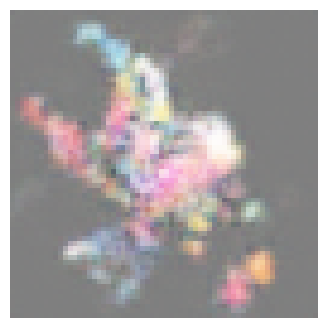

In [ ]:
# Generazione musicale
#Bisogna mettere il nome di una delle canzoni nella cartella del Drive
generate_grid_from_song("SbH", vae, pkms, device, n_show=1) # Generazione musicale

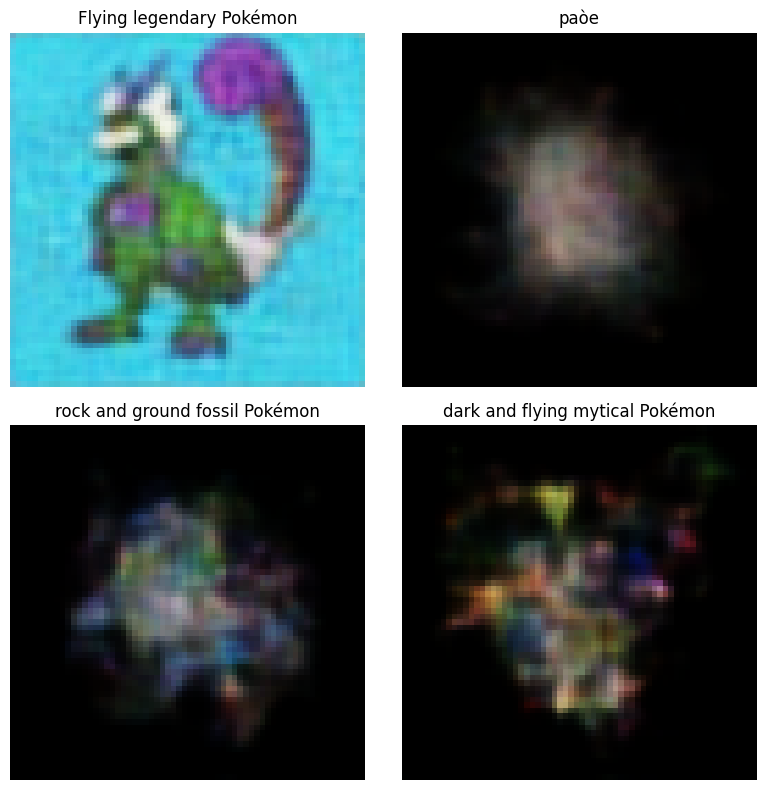

In [ ]:
# Generazione testuale
p = "rock and ground fossil Pokémon"
show_generated(p, model, vocab)